### Import Libraries

In [1]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings

In [2]:
# Suppress all warnings
warnings.filterwarnings("ignore")

### Data Collection

Set date as the index of the DataFrame and sort index in ascending order

In [3]:
# read excel file and store as df
df = pd.read_excel('S&P500.xlsx').drop(columns=['Adj Close']).set_index('Date').sort_index(ascending=True)

# set freq
freq = pd.infer_freq(df.index)

# set target
target = 'Close'

df

,Open,High,Low,Close,Volume
Date,,,,,
1985-01-01,167.20,180.27,163.36,179.63,2673710000
1985-02-01,179.63,183.95,177.75,181.18,2194620000
1985-03-01,181.18,183.89,176.53,180.66,2153090000
1985-04-01,180.66,183.61,177.86,179.83,1981880000
1985-05-01,179.83,189.98,178.35,189.55,2350340000
...,...,...,...,...,...
2023-06-01,4183.03,4458.48,4171.64,4450.38,87983140000
2023-07-01,4450.48,4607.07,4385.05,4588.96,75063200000
2023-08-01,4578.83,4584.62,4335.31,4507.66,86840820000


### Seasonal Decomposition 

##### Is there Seasonality in the Time Series? What is the best m?

- The seasonal period/order (m) is likely the lag position where autocorrelation or partial autocorrelation sharply decreases, signaling the presence of a seasonal pattern in the data.

- If the ACF and PACF suggest different values for m, it could imply that the seasonality in the time series is not straightforward or does not strictly follow a single pattern.

- If one plot indicates a value for m, while the other does not, it may suggest the presence of more complex temporal patterns, possibly involving multiple seasonal components or a combination of trends.

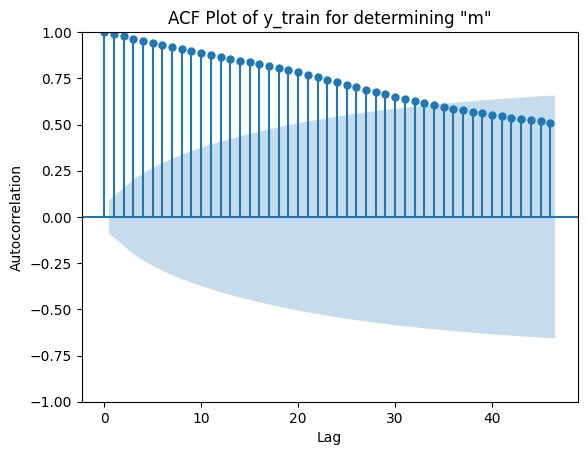

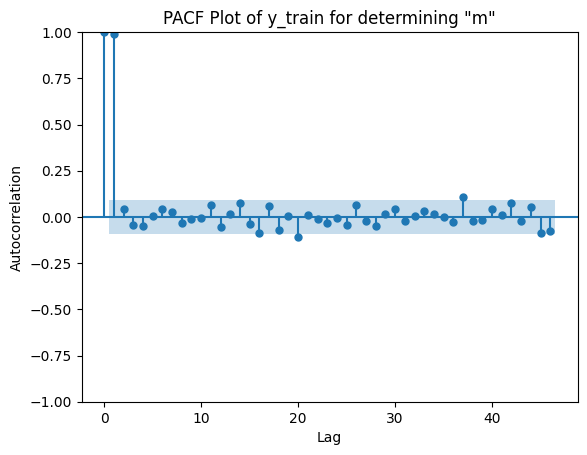

In [4]:
def find_best_m(series):
     
    # Plot ACF using the plot_acf function on undifferenced y_train
    plot_acf(series, lags=int(0.1 * len(series)))
    plt.title('ACF Plot of y_train for determining "m"')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    # Plot PACF using the plot_acf function on undifferenced y_train
    plot_pacf(series, lags=int(0.1 * len(series)))
    plt.title('PACF Plot of y_train for determining "m"')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    

# Call the function with your y_train data
find_best_m(df[target])

In [5]:
# Set value 
# m=1 means no seasonality
# do not set m=0 as its not meaningful
# set m=x for any identified seasonality
m = 1 

print(f"Estimated m: {m}")

Estimated m: 1


##### Auto Seasonal Decomposition

Selected Model: additive
Selected Period: 1


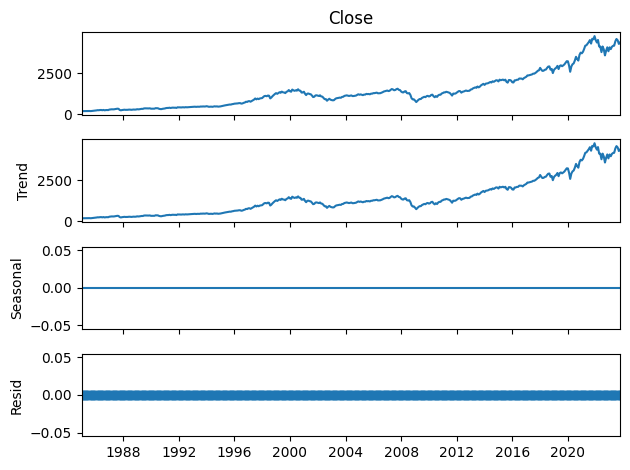

In [6]:
# Function to automate decomposition model and seasonality period selection
def auto_decompose(series):
    # Perform ADF test for stationarity
    result_adf = adfuller(series)
    is_stationary = result_adf[1] < 0.05  # Check if p-value is less than 0.05

    # Choose decomposition model based on stationarity
    selected_model = 'multiplicative' if is_stationary else 'additive'

    # retrieve selected period
    selected_period = m
    
    print(f"Selected Model: {selected_model}")
    print(f"Selected Period: {selected_period}")

    return selected_model , selected_period

# Perform automated decomposition model and seasonality period selection
selected_model, selected_period = auto_decompose(df[target])

# Perform seasonal decomposition with the selected model and period
result = seasonal_decompose(df[target], model=selected_model, period=selected_period)

# Plot the decomposed components
result.plot()
plt.show()

### Feature Engineering

In [7]:
def extract_calendar_features(dataframe):
    
    # Extract calendar features from the index
    dataframe['year'] = dataframe.index.year
    dataframe['month'] = dataframe.index.month
    dataframe['day'] = dataframe.index.day
    dataframe['day_of_week'] = dataframe.index.dayofweek  # Monday is 0 and Sunday is 6
    dataframe['day_of_year'] = dataframe.index.dayofyear
    dataframe['week_of_year'] = dataframe.index.isocalendar().week

    return dataframe

# Create calendar features for the DataFrame with a datetime index
df = extract_calendar_features(df)

In [8]:
def extract_lag_features(dataframe, target, num_lags):

    for lag in range(1, num_lags + 1):
        dataframe[f"lag_{lag}"] = dataframe[target].shift(lag)
        
    dataframe = dataframe.dropna()

    return dataframe

# Add lag features for the 'target_column' with n lags
df = extract_lag_features(df, target, num_lags=3)

### Data Split

In [9]:
X = df[[item for item in df.columns if item != target]]
y = df[target]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=42, shuffle=False)

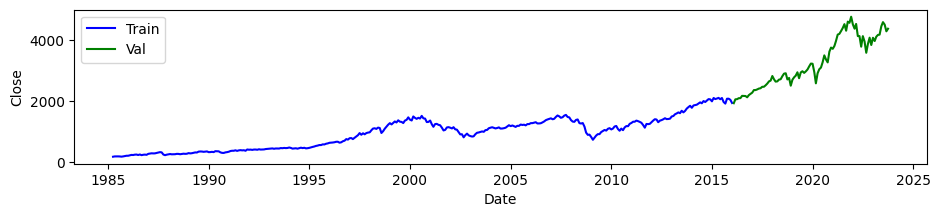

In [11]:
# Plot Train-Val Set
plt.figure(figsize=(11,2))
sns.lineplot(y_train, label = 'Train', color = 'blue')
sns.lineplot(y_val, label = 'Val', color = 'green')
plt.legend()
plt.show()

### Time Series Modeling with Simple Regressors (with External Variables)

##### Identyfying Feature Types

In [12]:
# Assuming you have lists of numerical and categorical column names
numerical_cols = df.select_dtypes(include=[int, float]).columns.to_list()
categorical_cols = df.select_dtypes(include=[object]).columns.to_list()

# Removing the target from numerical & categorical columns
numerical_cols = [col for col in numerical_cols if target not in col]
categorical_cols = [col for col in categorical_cols if target not in col]

##### Handling Numerical and Categorical Features

In [13]:
# Handling numerical variables with StandardScaler
if numerical_cols:
    std_scaler = StandardScaler()
    X_train_numerical = std_scaler.fit_transform(X_train[numerical_cols])
    X_val_numerical = std_scaler.transform(X_val[numerical_cols])

# Handling categorical variables with Label Encoding
if categorical_cols:
    label_encoder = LabelEncoder()
    X_train_categorical = label_encoder.fit_transform(X_train[categorical_cols])
    X_val_categorical = label_encoder.transform(X_val[categorical_cols])

##### Concatenate Numerical and Categorical features

In [14]:
# Concatenating processed numerical and categorical data if both exist
if numerical_cols and categorical_cols:
    X_train_processed = np.hstack([X_train_numerical, X_train_categorical])
    X_val_processed = np.hstack([X_val_numerical, X_val_categorical])
else:
    # Renaming if either numerical or categorical array is missing
    X_train = X_train_numerical if numerical_cols else X_train_categorical
    X_val = X_val_numerical if numerical_cols else X_val_categorical

##### Simple ML Regressor Leaderboard

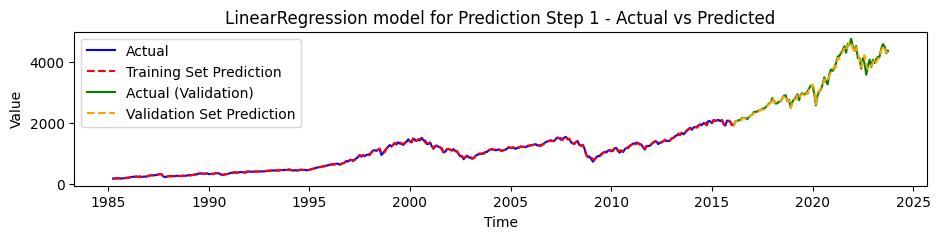

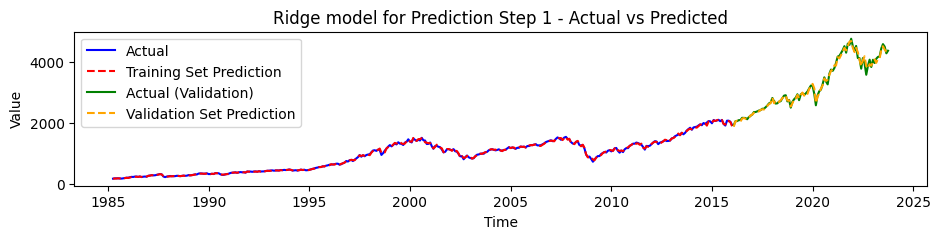

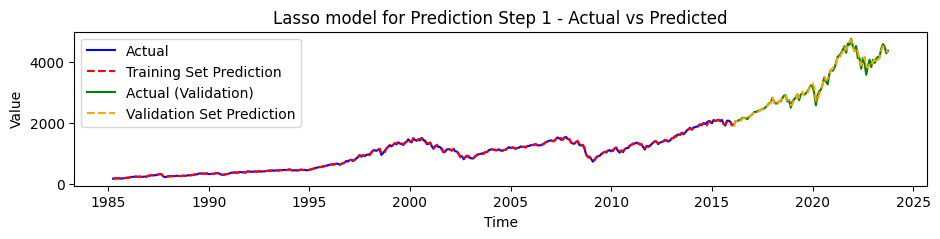

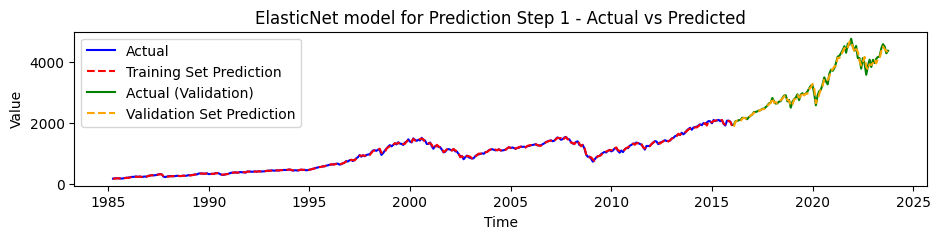

  - Training for Prediction Step 1/3 complete!



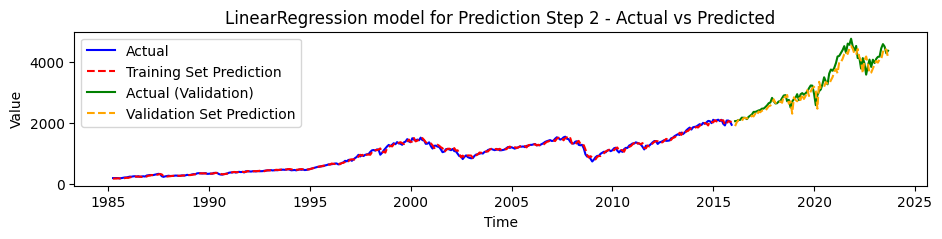

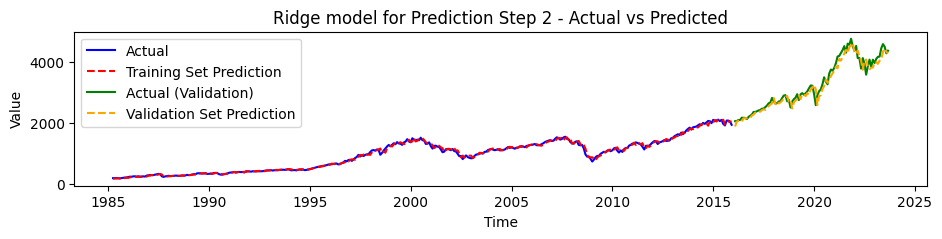

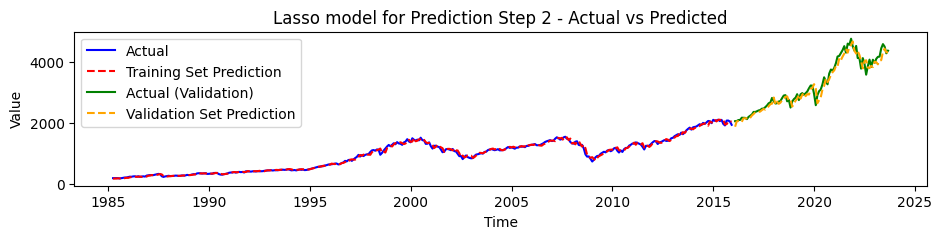

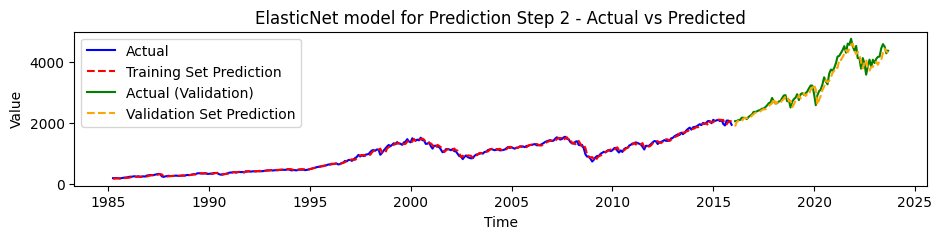

  - Training for Prediction Step 2/3 complete!



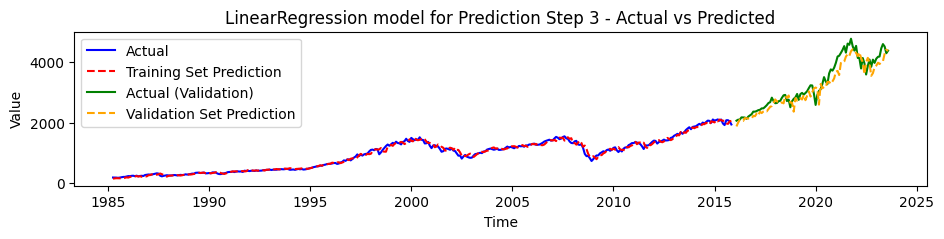

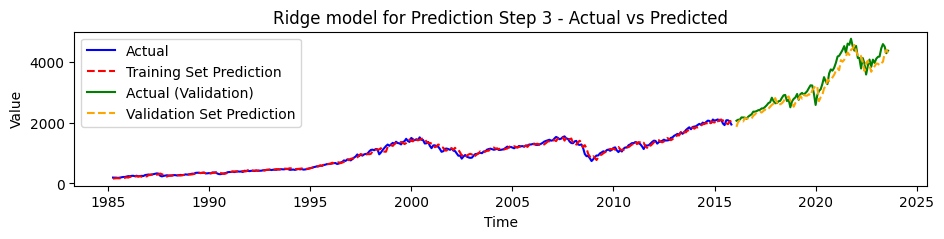

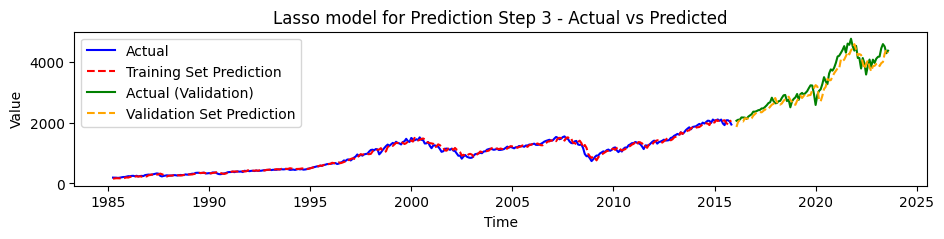

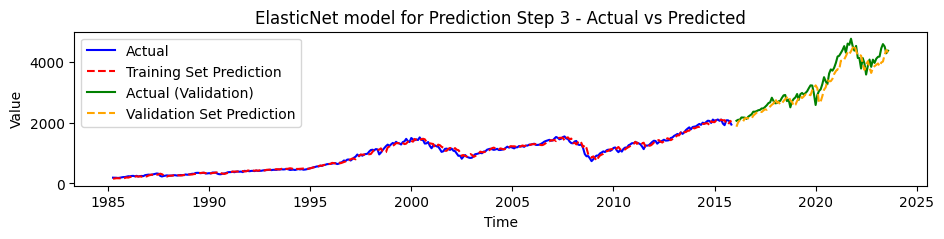

  - Training for Prediction Step 3/3 complete!



,Model,Prediction_Step,Params,MSE_Train,RMSE_Train,MAE_Train,MSE_Val,RMSE_Val,MAE_Val
1,Ridge,1,{'alpha': 0.01},368.299365,19.191127,13.138760,5237.864503,72.373092,53.386694
2,Lasso,1,{'alpha': 0.1},378.188901,19.447079,13.419630,5854.819100,76.516790,56.072464
0,LinearRegression,1,{},364.342293,19.087752,12.994706,5968.210616,77.254195,56.209207
3,ElasticNet,1,"{'l1_ratio': 0.9, 'alpha': 0.01}",399.361896,19.984041,13.887016,6184.795557,78.643471,60.601276
6,Lasso,2,{'alpha': 0.01},2034.118521,45.101203,31.426507,29959.616183,173.088463,135.413799
5,Ridge,2,{'alpha': 0.01},2005.736227,44.785447,31.325170,30826.620530,175.575114,136.644255
7,ElasticNet,2,"{'l1_ratio': 0.9, 'alpha': 0.01}",2058.354587,45.369093,31.675480,31454.717510,177.354779,137.787878
4,LinearRegression,2,{},1967.785019,44.359723,31.381684,43626.895364,208.870523,160.075825
10,Lasso,3,{'alpha': 0.1},3731.365953,61.084908,42.885356,53861.270792,232.080311,191.991168
9,Ridge,3,{'alpha': 0.01},3694.662941,60.783739,42.948396,54209.469748,232.829272,193.807268


In [15]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Function to visualize predictions
def visualize_predictions(y_train, pred_train, y_val, pred_val, model_name, pred_step):
    plt.figure(figsize=(11, 2))
    plt.plot(y_train.index, y_train, label='Actual', color='blue')
    plt.plot(y_train.index, pred_train, label='Training Set Prediction', color='red', linestyle='--')
    plt.plot(y_val.index, y_val, label='Actual (Validation)', color='green')
    plt.plot(y_val.index, pred_val, label='Validation Set Prediction', color='orange', linestyle='--')
    plt.title(f'{model_name} model for Prediction Step {pred_step} - Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def find_best_ML_models(X_train, y_train, X_val, y_val, output_length):
    
    # output length for predictions
    output_length= output_length
    
    # List to store results for all time steps
    all_results_list = []

    for i in range(0, output_length):
        # Adjust training data for each time step
        if i == 0:
            y_train_current = y_train
            X_train_current = X_train
            y_val_current = y_val
            X_val_current = X_val
        else:
            y_train_current = y_train.shift(-i).dropna()
            X_train_current = X_train[:-i]
            y_val_current = y_val.shift(-i).dropna()
            X_val_current = X_val[:-i]

        # Time Series Cross-Validation Setup
        tscv = TimeSeriesSplit(n_splits=5)

        # List of Regressors
        regressors = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]

        # Hyperparameter Grids
        lr_grid = {}
        ridge_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
        lasso_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
        elastic_net_grid = {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}

        distributions = [lr_grid, ridge_grid, lasso_grid, elastic_net_grid]

        # List to store results for the current time step
        results_list = []

        for regressor, distribution in zip(regressors, distributions):
            # Randomized Search Cross-Validation
            rscv = RandomizedSearchCV(regressor, distribution, random_state=0, cv=tscv, n_iter=5, scoring='neg_root_mean_squared_error')
            rscv.fit(X_train_current, y_train_current)
            
            # Generate predictions for training and validation sets
            y_train_pred = rscv.predict(X_train_current)
            y_val_pred = rscv.predict(X_val_current)
            
            # Evaluate model performance
            mse_train, rmse_train, mae_train = evaluate_model(y_train_current, y_train_pred)
            mse_val, rmse_val, mae_val = evaluate_model(y_val_current, y_val_pred)

            # Get Prediction Step
            pred_step = i + 1

            # Adding to the results list for the current time step
            results_list.append({
                'Model': type(rscv.best_estimator_).__name__,
                'Prediction_Step': pred_step,  # Adding +1 since range starts at zero in the for loop
                'Params': rscv.best_params_,
                'MSE_Train': mse_train,
                'RMSE_Train': rmse_train,
                'MAE_Train': mae_train,
                'MSE_Val': mse_val,
                'RMSE_Val': rmse_val,
                'MAE_Val': mae_val
            })
            
            # Get Model Name
            model_name = type(regressor).__name__
            
            # Visualize Predictions
            visualize_predictions(y_train_current, y_train_pred, y_val_current, y_val_pred, model_name, pred_step)

        # Add results for the current time step to the list for all time steps
        all_results_list.extend(results_list)
        
        # Print status of training
        print(f"  - Training for Prediction Step {pred_step}/{output_length} complete!")
        print()


    # Convert the list of results for all time steps to a DataFrame
    all_results_df = pd.DataFrame(all_results_list)

    # Sort results by Prediction Step & RMSE
    all_results_df = all_results_df.sort_values(by=['Prediction_Step', 'RMSE_Val', 'RMSE_Train'])

    return all_results_df


# Assuming X_train, y_train, X_val, and y_val are defined
all_results_df = find_best_ML_models(X_train, y_train, X_val, y_val, output_length=3)
all_results_df

##### Best Simple ML Regressor for each Time Step

In [16]:
# Keep only the first row for each Prediction_Step
filtered_all_results_df = all_results_df.drop_duplicates(subset='Prediction_Step', keep='first')

filtered_all_results_df

,Model,Prediction_Step,Params,MSE_Train,RMSE_Train,MAE_Train,MSE_Val,RMSE_Val,MAE_Val
1,Ridge,1,{'alpha': 0.01},368.299365,19.191127,13.138760,5237.864503,72.373092,53.386694
6,Lasso,2,{'alpha': 0.01},2034.118521,45.101203,31.426507,29959.616183,173.088463,135.413799
10,Lasso,3,{'alpha': 0.1},3731.365953,61.084908,42.885356,53861.270792,232.080311,191.991168


##### Best Simple ML Regressor Summary

In [17]:
# calculate the mean of all scores
average_scores = filtered_all_results_df[['MSE_Train', 'RMSE_Train','MAE_Train', 'MSE_Val', 'RMSE_Val', 'MAE_Val']].mean()

# create a df with average_scores
results_df_ML_A = pd.DataFrame(average_scores).transpose()

# append Model names, Predtion Step, and Params in the same row
results_df_ML_A['Model'] = ' + '.join(filtered_all_results_df['Model'])
results_df_ML_A['Prediction_Step'] = ' + '.join(map(str, filtered_all_results_df['Prediction_Step']))
results_df_ML_A['Params'] = ' + '.join(str(params) for params in filtered_all_results_df['Params'])

# rearrange columns
results_df_ML_A = results_df_ML_A[['Model', 'Params', 
                                   'MSE_Train', 'RMSE_Train', 'MAE_Train', 
                                   'MSE_Val', 'RMSE_Val', 'MAE_Val']]

results_df_ML_A

,Model,Params,MSE_Train,RMSE_Train,MAE_Train,MSE_Val,RMSE_Val,MAE_Val
0,Ridge + Lasso + Lasso,{'alpha': 0.01} + {'alpha': 0.01} + {'alpha': ...,2044.594613,41.792413,29.150208,29686.250493,159.180622,126.930554
